In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
import keras_tuner as kt
from keras_tuner import RandomSearch
from GEH_LOSS import rGEH_loss
import geh as ga

In [3]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [4]:
import relative_accuracy as ra

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5_multi.npz")['x'] 
Output_train_5 = np.load("Deep_train_5_multi.npz")['y']

Deep_test_5   = np.load("Deep_test_5_multi.npz")['x'] 
Output_test_5 = np.load("Deep_test_5_multi.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15_multi.npz")['x'] 
Output_train_15 = np.load("Deep_train_15_multi.npz")['y']

Deep_test_15   = np.load("Deep_test_15_multi.npz")['x'] 
Output_test_15 = np.load("Deep_test_15_multi.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30_multi.npz")['x'] 
Output_train_30 = np.load("Deep_train_30_multi.npz")['y']

Deep_test_30   = np.load("Deep_test_30_multi.npz")['x'] 
Output_test_30 = np.load("Deep_test_30_multi.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60_multi.npz")['x'] 
Output_train_60 = np.load("Deep_train_60_multi.npz")['y']

Deep_test_60   = np.load("Deep_test_60_multi.npz")['x'] 
Output_test_60 = np.load("Deep_test_60_multi.npz")['y']

In [6]:
# Wide Data
Xtrain = joblib.load("002weeks_train_Multi.save") 
Xtest = joblib.load("002weeks_test_Multi.save") 

In [7]:
# 5 mins
# Delete first 15 samples
Wide_train_5 = np.delete(Xtrain, np.s_[0:15], 0)
Wide_test_5 = np.delete(Xtest, np.s_[0:15], 0)

In [8]:
# 15 mins
# Delete first 17 samples
Wide_train_15 = np.delete(Xtrain, np.s_[0:17], 0)
Wide_test_15 = np.delete(Xtest, np.s_[0:17], 0)

In [9]:
# 30 mins
# Delete first 20 samples
Wide_train_30 = np.delete(Xtrain, np.s_[0:20], 0)
Wide_test_30 = np.delete(Xtest, np.s_[0:20], 0)

In [10]:
# 60 mins
# Delete first 27 samples
Wide_train_60 = np.delete(Xtrain, np.s_[0:26], 0)
Wide_test_60 = np.delete(Xtest, np.s_[0:26], 0)

In [11]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

In [12]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [13]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 6                # No of loop detectors
n_seq = 3                     # Subsequences
n_steps = 5                   # time-step per subsequence
# val_percent = 0.07567       # 2 weeks
val_percent = 0.2        
batch_size = 32

n_seq_ = 3                     # Subsequences
n_steps_ = 3                   # time-step per subsequence

#### 5 mins

In [14]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = scaler.inverse_transform(Output_train_5)

In [15]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = scaler.inverse_transform(Output_test_5)

#### 15 mins

In [16]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = scaler.inverse_transform(Output_train_15)

In [17]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = scaler.inverse_transform(Output_test_15)

#### 30 mins

In [18]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = scaler.inverse_transform(Output_train_30)

In [19]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = scaler.inverse_transform(Output_test_30)

#### 60 mins

In [20]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = scaler.inverse_transform(Output_train_60)

In [21]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = scaler.inverse_transform(Output_test_60)

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [22]:
# define no_of_channels
n_channels = 1

In [23]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [24]:
Wt5  = Wide_train_5
Wt15 = Wide_train_15
Wt30 = Wide_train_30
Wt60 = Wide_train_60

Wv5  = Wide_test_5
Wv15 = Wide_test_15
Wv30 = Wide_test_30
Wv60 = Wide_test_60

In [25]:
# Train data
Wt5  =  Wt5.reshape(Wt5.shape[0], n_seq_, n_steps_, n_features)
Wt15 =  Wt15.reshape(Wt15.shape[0], n_seq_, n_steps_, n_features)
Wt30 =  Wt30.reshape(Wt30.shape[0], n_seq_, n_steps_, n_features)
Wt60 =  Wt60.reshape(Wt60.shape[0], n_seq_, n_steps_, n_features)

# Validation data
Wv5  =  Wv5.reshape(Wv5.shape[0], n_seq_, n_steps_, n_features)
Wv15 =  Wv15.reshape(Wv15.shape[0], n_seq_, n_steps_, n_features)
Wv30 =  Wv30.reshape(Wv30.shape[0], n_seq_, n_steps_, n_features)
Wv60 =  Wv60.reshape(Wv60.shape[0], n_seq_, n_steps_, n_features)

In [26]:
Xt5.shape

(49233, 3, 5, 6, 1)

In [27]:
Wt5.shape

(49233, 3, 3, 6)

# CNN-LSTM model

In [28]:
from tensorflow import keras
from keras_self_attention import SeqSelfAttention

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights = True)

In [29]:
Wide_train_5.shape

(49233, 9, 6)

# 5 mins ahead

In [30]:
def build_model_5(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt5.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt5.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_5w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_5 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_5w)
    
    
    # Deep Model
    # CNN 
    CNN_5 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_5 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_5)
    # LSTM          
    LSTM_5 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_5)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_5, LSTM_5], axis=1)

    # Attention
    Att_5 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_5)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_5 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=rGEH_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                                   
    return model_5

In [31]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8d-5",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8d-5\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8d-5\tuner0.json


In [32]:
tuner5.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [33]:
tuner5.search((Wt5,Xt5), yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

Trial 61 Complete [00h 17m 51s]
val_loss: 4.175632953643799

Best val_loss So Far: 4.058511018753052
Total elapsed time: 00h 38m 12s
INFO:tensorflow:Oracle triggered exit


In [34]:
tuner5.results_summary(1)

Results summary
Results in C:\RunsOak\8d-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 96
filters: 416
kernel_size: 2
learning_rate: 0.001
Score: 4.058511018753052


### Best Model

In [35]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [36]:
scaler_filename = "Best_HP/8d-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/8d-5']

In [37]:
model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 4, 5, 416  2080       ['DeepInput[0][0]']              
 buted)                         )                                                                 
                                                                                            

In [38]:
model5.fit((Wt5,Xt5), yt5, 
           epochs = 100, 
           verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 64s 33ms/step - loss: 6.3746 - mean_absolute_error: 20.3715 - root_mean_squared_error: 33.5633 - mean_absolute_percentage_error: 28.3586 8s - loss: 6.6705 - mean_absolute_error: 21.2502 - root_mean_squared_error: 35.3465 - mean_absolute_percentage - ETA: 7s - l
Epoch 2/100
1539/1539 [==============================] - 51s 33ms/step - loss: 4.6450 - mean_absolute_error: 15.1818 - root_mean_squared_error: 21.7589 - mean_absolute_percentage_error: 20.4195 4s - loss: 4.6631 - mean_absolute_error: 15.2279 - 
Epoch 3/100
1539/1539 [==============================] - 51s 33ms/step - loss: 4.4074 - mean_absolute_error: 14.4837 - root_mean_squared_error: 20.8293 - mean_absolute_percentage_error: 18.9426
Epoch 4/100
1539/1539 [==============================] - 51s 33ms/step - loss: 4.2849 - mean_absolute_error: 14.1292 - root_mean_squared_error: 20.3738 - mean_absolute_percentage_error: 18.0667
Epoch 5/100
1539/1539 [========================

1539/1539 [==============================] - 45s 29ms/step - loss: 3.5178 - mean_absolute_error: 11.9432 - root_mean_squared_error: 17.8576 - mean_absolute_percentage_error: 13.7861
Epoch 74/100
1539/1539 [==============================] - 45s 29ms/step - loss: 3.5133 - mean_absolute_error: 11.9312 - root_mean_squared_error: 17.8471 - mean_absolute_percentage_error: 13.7683
Epoch 75/100
1539/1539 [==============================] - 45s 29ms/step - loss: 3.5056 - mean_absolute_error: 11.9112 - root_mean_squared_error: 17.8291 - mean_absolute_percentage_error: 13.7142
Epoch 76/100
1539/1539 [==============================] - 41s 26ms/step - loss: 3.5036 - mean_absolute_error: 11.8985 - root_mean_squared_error: 17.8068 - mean_absolute_percentage_error: 13.7280
Epoch 77/100
1539/1539 [==============================] - 43s 28ms/step - loss: 3.4942 - mean_absolute_error: 11.8769 - root_mean_squared_error: 17.7853 - mean_absolute_percentage_error: 13.6746
Epoch 78/100
1539/1539 [==============

In [39]:
model5.save("my_dir/8d-5")

INFO:tensorflow:Assets written to: my_dir/8d-5\assets


INFO:tensorflow:Assets written to: my_dir/8d-5\assets


In [40]:
metrics5 = pd.DataFrame(model5.history.history)

<AxesSubplot:>

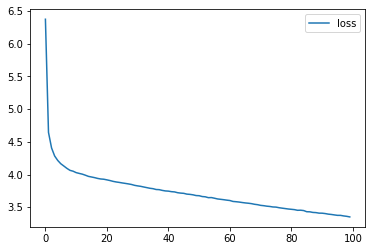

In [41]:
metrics5[['loss']].plot()

In [33]:
model5 = keras.models.load_model("my_dir/8d-5", custom_objects={'rGEH_loss': rGEH_loss}) 

In [34]:
model5.predict((Wv5,Xv5))

array([[29.053188 , 16.721489 , 32.799232 , 71.95916  , 24.869194 ,
         4.9959774],
       [28.929882 , 16.415453 , 36.43313  , 75.49485  , 30.994064 ,
         4.8589067],
       [27.997463 , 14.846355 , 35.096813 , 71.31339  , 26.277237 ,
         5.0040784],
       ...,
       [43.453922 , 42.04916  , 48.92824  , 98.40154  , 42.710102 ,
         9.96608  ],
       [42.373676 , 39.59094  , 45.978073 , 83.752495 , 35.61307  ,
        10.294956 ],
       [41.692425 , 37.85958  , 53.59384  , 96.39124  , 38.791096 ,
         8.823437 ]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions5 = model5.predict((Wv5,Xv5))


MSE5 = mean_squared_error(yv5,test_predictions5)

MAE5 = mean_absolute_error(yv5,test_predictions5)

RMSE5 = np.sqrt(MSE5)

MAPE5 = mean_absolute_percentage_error(yv5,test_predictions5)*100

eval5 = [MSE5, MAE5, RMSE5, MAPE5]
print(eval5)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))
GEH5 = count/GEH.size
print(GEH5)

# 15 mins ahead

In [37]:
def build_model_15(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt15.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt15.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_15w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_15 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_15w)
    
    
    # Deep Model
    # CNN 
    CNN_15 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_15 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_15)
    # LSTM          
    LSTM_15 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_15)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_15, LSTM_15], axis=1)

    # Attention
    Att_15 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_15)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_15 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=rGEH_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_15

In [38]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8d-15",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8d-15\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8d-15\tuner0.json


In [39]:
tuner15.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [49]:
tuner15.search((Wt15,Xt15), yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

Trial 60 Complete [00h 16m 21s]
val_loss: 4.493234395980835

Best val_loss So Far: 4.33412766456604
Total elapsed time: 08h 17m 14s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [50]:
tuner15.results_summary(1)

Results summary
Results in C:\RunsOak\8d-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 40
filters: 256
kernel_size: 2
learning_rate: 0.001
Score: 4.33412766456604


### Best model

In [51]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp15)

In [52]:
scaler_filename = "Best_HP/8d-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/8d-15']

In [53]:
model15.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 4, 5, 256  1280       ['DeepInput[0][0]']              
 buted)                         )                                                                 
                                                                                            

In [54]:
model15.fit((Wt15,Xt15), yt15, 
            epochs = 100, 
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 39s 23ms/step - loss: 6.8836 - mean_absolute_error: 21.8579 - root_mean_squared_error: 36.2697 - mean_absolute_percentage_error: 30.8939 4s - loss: 7.0850 - mean_absolute_error: 22.4152 - root_mean_s
Epoch 2/100
1539/1539 [==============================] - 35s 23ms/step - loss: 5.1377 - mean_absolute_error: 16.8281 - root_mean_squared_error: 24.2790 - mean_absolute_percentage_error: 22.5960
Epoch 3/100
1539/1539 [==============================] - 35s 23ms/step - loss: 4.8601 - mean_absolute_error: 15.9975 - root_mean_squared_error: 23.0611 - mean_absolute_percentage_error: 21.2044 1s - loss: 4.8597 - mean_absolute_error: 15.9914 - root_mean_squared_error: 23.0503 - mean_absolute_percentage_er - ETA: 0s - loss: 4.8585 - mean_absolute_error: 15.9914 - root_mean_squared_error: 23.0536 - mean_absolute_percentage_e
Epoch 4/100
1539/1539 [==============================] - 35s 23ms/step - loss: 4.7340 - mean_absolute_error: 15.6461 - ro

1539/1539 [==============================] - 36s 23ms/step - loss: 3.9577 - mean_absolute_error: 13.2948 - root_mean_squared_error: 19.7442 - mean_absolute_percentage_error: 16.3981 6s - loss: 3.9601 - mean_ab
Epoch 73/100
1539/1539 [==============================] - 36s 23ms/step - loss: 3.9542 - mean_absolute_error: 13.2872 - root_mean_squared_error: 19.7281 - mean_absolute_percentage_error: 16.3586 11s  - ETA: 5s - loss: 3.9586 - mean_absolute_error: 1
Epoch 74/100
1539/1539 [==============================] - 36s 23ms/step - loss: 3.9430 - mean_absolute_error: 13.2508 - root_mean_squared_error: 19.7002 - mean_absolute_percentage_error: 16.2931 3s - loss: 3.9390 - mean_absolute_error: 13.2411 - root_mean_squared_
Epoch 75/100
1539/1539 [==============================] - 36s 23ms/step - loss: 3.9433 - mean_absolute_error: 13.2552 - root_mean_squared_error: 19.7145 - mean_absolute_percentage_error: 16.3081
Epoch 76/100
1539/1539 [==============================] - 36s 23ms/step - loss: 

In [55]:
model15.save("my_dir/8d-15")

INFO:tensorflow:Assets written to: my_dir/8d-15\assets


INFO:tensorflow:Assets written to: my_dir/8d-15\assets


In [56]:
metrics15 = pd.DataFrame(model15.history.history)

<AxesSubplot:>

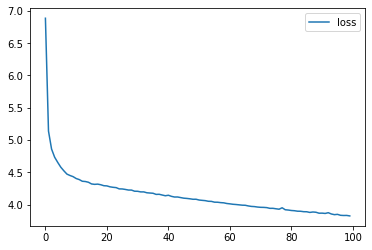

In [57]:
metrics15[['loss']].plot()

In [40]:
model15 = keras.models.load_model("my_dir/8d-15", custom_objects={'rGEH_loss': rGEH_loss})

In [41]:
model15.predict((Wv15,Xv15))

array([[ 28.953794 ,  17.61628  ,  26.197735 ,  65.75953  ,  27.640066 ,
          5.078393 ],
       [ 28.512892 ,  16.504686 ,  24.338223 ,  66.841095 ,  27.580746 ,
          5.124794 ],
       [ 29.841291 ,  17.422531 ,  26.997944 ,  66.04064  ,  28.762716 ,
          5.0387635],
       ...,
       [ 44.242443 ,  43.503746 ,  65.448906 , 111.07852  ,  51.51123  ,
          8.218998 ],
       [ 42.308952 ,  40.63667  ,  52.752586 , 109.18111  ,  54.151047 ,
         16.483688 ],
       [ 38.737034 ,  35.456894 ,  56.699005 , 109.01261  ,  51.353516 ,
          8.703751 ]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions15 = model15.predict((Wv15,Xv15))


MSE15 = mean_squared_error(yv15,test_predictions15)

MAE15 = mean_absolute_error(yv15,test_predictions15)

RMSE15 = np.sqrt(MSE15)

MAPE15 = mean_absolute_percentage_error(yv15,test_predictions15)*100

eval15 = [MSE15, MAE15, RMSE15, MAPE15]
print(eval15)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv15), np.asarray(test_predictions15))
GEH15 = count/GEH.size
print(GEH15)

# 30 mins ahead

In [44]:
def build_model_30(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt30.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt30.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_30w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_30 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_30w)
    
    
    # Deep Model
    # CNN 
    CNN_30 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_30 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_30)
    # LSTM          
    LSTM_30 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_30)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_30, LSTM_30], axis=1)

    # Attention
    Att_30 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_30)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_30 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=rGEH_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_30

In [45]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8d-30",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8d-30\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8d-30\tuner0.json


In [46]:
tuner30.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [65]:
tuner30.search((Wt30,Xt30), yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 60 Complete [00h 43m 15s]
val_loss: 5.693761587142944

Best val_loss So Far: 4.546577215194702
Total elapsed time: 03h 03m 29s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [66]:
tuner30.results_summary(1)

Results summary
Results in C:\RunsOak\8d-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 69
filters: 320
kernel_size: 2
learning_rate: 0.001
Score: 4.546577215194702


### Best model

In [67]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp30)

In [68]:
scaler_filename = "8d-30"
joblib.dump(best_hp30, scaler_filename) 

['8d-30']

In [69]:
model30.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 4, 5, 320  1600       ['DeepInput[0][0]']              
 buted)                         )                                                                 
                                                                                            

In [70]:
model30.fit((Wt30,Xt30), yt30, 
            epochs = 100, 
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 60s 37ms/step - loss: 7.1182 - mean_absolute_error: 22.8891 - root_mean_squared_error: 36.9918 - mean_absolute_percentage_error: 32.1302
Epoch 2/100
1539/1539 [==============================] - 57s 37ms/step - loss: 5.5098 - mean_absolute_error: 18.0958 - root_mean_squared_error: 26.1784 - mean_absolute_percentage_error: 24.3973 0s - loss: 5.5109 - mean_absolute_error: 18.0980 - root_mean_squared_error: 26.1850 - mean_absolute_percentage_e
Epoch 3/100
1539/1539 [==============================] - 57s 37ms/step - loss: 5.1924 - mean_absolute_error: 17.1301 - root_mean_squared_error: 24.6791 - mean_absolute_percentage_error: 22.3495
Epoch 4/100
1539/1539 [==============================] - 57s 37ms/step - loss: 5.0576 - mean_absolute_error: 16.7397 - root_mean_squared_error: 24.2195 - mean_absolute_percentage_error: 21.5845
Epoch 5/100
1539/1539 [==============================] - 57s 37ms/step - loss: 4.9377 - mean_absolute_error: 16

1539/1539 [==============================] - 56s 37ms/step - loss: 4.0397 - mean_absolute_error: 13.5910 - root_mean_squared_error: 20.3447 - mean_absolute_percentage_error: 16.6869 1s - loss: 4.0358 - mean_absolute_error: 13.5751 - root_mean_squared_error: 20.3135 - mean_absolute_p
Epoch 80/100
1539/1539 [==============================] - 56s 37ms/step - loss: 4.0237 - mean_absolute_error: 13.5387 - root_mean_squared_error: 20.2647 - mean_absolute_percentage_error: 16.6300 9s - loss: 4.0201 - mean_absolute_error: 13.5271 - root_mean_squared_err - ETA: 5s - loss: 4.0204 - mean_absolute_error: 13.5272 - root_mean_squared_error: 20.2412 - m - ETA: 2s - loss: 4.0221 - mean_absolute_error: 13.5348 - root_mean_squared_error: 20.2517 -
Epoch 81/100
1539/1539 [==============================] - 57s 37ms/step - loss: 4.0201 - mean_absolute_error: 13.5280 - root_mean_squared_error: 20.2571 - mean_absolute_percentage_error: 16.6138
Epoch 82/100
1539/1539 [==============================] - 56s 37m

In [71]:
model30.save("my_dir/8d-30")

INFO:tensorflow:Assets written to: my_dir/8d-30\assets


INFO:tensorflow:Assets written to: my_dir/8d-30\assets


In [72]:
metrics30 = pd.DataFrame(model30.history.history)

<AxesSubplot:>

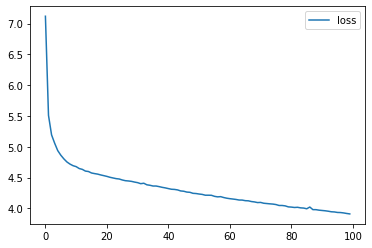

In [73]:
metrics30[['loss']].plot()

In [47]:
model30 = keras.models.load_model("my_dir/8d-30", custom_objects={'rGEH_loss': rGEH_loss})

In [48]:
model30.predict((Wv30,Xv30))

array([[ 27.984491 ,  13.966761 ,  32.208153 ,  61.202908 ,  31.365135 ,
          5.0193605],
       [ 27.154352 ,  13.140772 ,  14.561163 ,  60.124172 ,  29.963541 ,
          4.9208794],
       [ 28.580935 ,  14.174637 ,  20.40569  ,  59.90272  ,  31.56072  ,
          5.0190525],
       ...,
       [ 43.414787 ,  41.881153 ,  62.99355  , 114.706245 ,  55.90762  ,
          7.227172 ],
       [ 45.294945 ,  43.21314  ,  59.96069  , 108.91641  ,  52.010487 ,
          7.3697443],
       [ 40.507095 ,  36.81284  ,  55.723835 , 104.8098   ,  48.461895 ,
          9.155896 ]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions30 = model30.predict((Wv30,Xv30))


MSE30 = mean_squared_error(yv30,test_predictions30)

MAE30 = mean_absolute_error(yv30,test_predictions30)

RMSE30 = np.sqrt(MSE30)

MAPE30 = mean_absolute_percentage_error(yv30,test_predictions30)*100

eval30 = [MSE30, MAE30, RMSE30, MAPE30]
print(eval30)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv30), np.asarray(test_predictions30))
GEH30 = count/GEH.size
print(GEH30)

# 60 mins ahead

In [51]:
def build_model_60(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt60.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt60.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_60w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_60 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, return_sequences=True),
        merge_mode="ave"
    )(flatten_60w)
    
    
    # Deep Model
    # CNN 
    CNN_60 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_60 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_60)
    # LSTM          
    LSTM_60 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_60)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_60, LSTM_60], axis=1)

    # Attention
    Att_60 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_60)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_60 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=rGEH_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_60

In [52]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8d-60",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\8d-60\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\8d-60\tuner0.json


In [53]:
tuner60.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [54]:
tuner60.search((Wt60,Xt60), yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 61 Complete [00h 17m 51s]
val_loss: 4.935488700866699

Best val_loss So Far: 4.785287618637085
Total elapsed time: 04h 56m 30s
INFO:tensorflow:Oracle triggered exit


In [55]:
tuner60.results_summary(1)

Results summary
Results in C:\RunsOak\8d-60
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 86
filters: 96
kernel_size: 3
learning_rate: 0.001
Score: 4.785287618637085


### Best model

In [56]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [57]:
scaler_filename = "Best_HP/8d-60"
joblib.dump(best_hp60, scaler_filename) 

['Best_HP/8d-60']

In [58]:
model60.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6)]    0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 3, 4, 96)  960        ['DeepInput[0][0]']              
 buted)                                                                                           
                                                                                            

In [59]:
model60.fit((Wt60,Xt60), yt60, 
            epochs = 100, 
            verbose = 1
            )

Epoch 1/100
1539/1539 [==============================] - 22s 11ms/step - loss: 8.0818 - mean_absolute_error: 25.8004 - root_mean_squared_error: 41.0292 - mean_absolute_percentage_error: 37.5484 6s - loss: 9.2143 - mean_absolute_error: 28.9808 - root_mean_squared_error: 46.5336 - mean_absolute_perc - ETA: 5s - loss: 8.9319 - mean_absolute_error: 28.1719 - root_mean_squared_error: 45.1653 - mean_absolute_percentage_error: - ETA: 4s - loss: 8.8306 - mean_absolute_error: 27.8937 - root_mean_squared_error: 44.6881 - mean_absolute_percentage_err - ETA: 4s - loss: 8.6997 - mean_absolute_error: 27.5200 - root_me
Epoch 2/100
1539/1539 [==============================] - 17s 11ms/step - loss: 5.9235 - mean_absolute_error: 19.5319 - root_mean_squared_error: 28.3507 - mean_absolute_percentage_error: 26.1736
Epoch 3/100
1539/1539 [==============================] - 16s 11ms/step - loss: 5.5844 - mean_absolute_error: 18.4149 - root_mean_squared_error: 26.5973 - mean_absolute_percentage_error: 23.8352 

1539/1539 [==============================] - 17s 11ms/step - loss: 4.2860 - mean_absolute_error: 14.3729 - root_mean_squared_error: 21.5683 - mean_absolute_percentage_error: 17.8262
Epoch 70/100
1539/1539 [==============================] - 16s 11ms/step - loss: 4.2732 - mean_absolute_error: 14.3311 - root_mean_squared_error: 21.5157 - mean_absolute_percentage_error: 17.7922
Epoch 71/100
1539/1539 [==============================] - 16s 11ms/step - loss: 4.2661 - mean_absolute_error: 14.3029 - root_mean_squared_error: 21.4672 - mean_absolute_percentage_error: 17.7559
Epoch 72/100
1539/1539 [==============================] - 17s 11ms/step - loss: 4.2611 - mean_absolute_error: 14.2882 - root_mean_squared_error: 21.4636 - mean_absolute_percentage_error: 17.6503
Epoch 73/100
1539/1539 [==============================] - 16s 11ms/step - loss: 4.2543 - mean_absolute_error: 14.2610 - root_mean_squared_error: 21.4204 - mean_absolute_percentage_error: 17.7119
Epoch 74/100
1539/1539 [==============

In [60]:
model60.save("my_dir/8d-60")

INFO:tensorflow:Assets written to: my_dir/8d-60\assets


INFO:tensorflow:Assets written to: my_dir/8d-60\assets


In [61]:
metrics60 = pd.DataFrame(model60.history.history)

<AxesSubplot:>

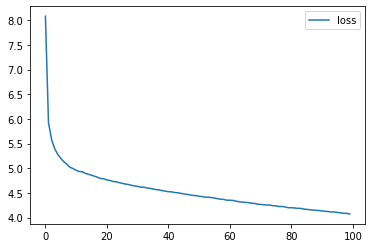

In [62]:
metrics60[['loss']].plot()

In [63]:
model60 = keras.models.load_model("my_dir/8d-60", custom_objects={'rGEH_loss': rGEH_loss})

In [64]:
model60.predict((Wv60,Xv60))

array([[ 26.811428 ,  12.054482 ,  19.355532 ,  57.30116  ,  29.672113 ,
          4.852217 ],
       [ 25.746208 ,  10.074606 ,  11.956555 ,  55.67801  ,  30.777142 ,
          4.8221927],
       [ 26.157873 ,  11.396345 ,  11.586244 ,  55.688877 ,  33.317406 ,
          4.8959846],
       ...,
       [ 40.18484  ,  36.318348 ,  60.280083 , 130.6921   ,  54.15426  ,
          7.3948717],
       [ 38.999557 ,  34.38743  ,  54.507057 , 122.37762  ,  51.286545 ,
          6.747251 ],
       [ 39.951088 ,  37.134716 ,  56.193577 , 116.91752  ,  50.90887  ,
          6.6972485]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions60 = model60.predict((Wv60,Xv60))


MSE60 = mean_squared_error(yv60,test_predictions60)

MAE60 = mean_absolute_error(yv60,test_predictions60)

RMSE60 = np.sqrt(MSE60)

MAPE60 = mean_absolute_percentage_error(yv60,test_predictions60)*100

eval60 = [MSE60, MAE60, RMSE60, MAPE60]
print(eval60)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv60), np.asarray(test_predictions60))
GEH60 = count/GEH.size
print(GEH60)